**Table of contents**<a id='toc0_'></a>    
- [ Прогнозирование заказов такси](#toc1_)    
- [Импорт библиотек и данных, первичный осмотр](#toc2_)    
- [Анализ временного ряда](#toc3_)    
  - [<font color='orange'>**Ресемплирование**</font>](#toc3_1_)    
  - [<font color='orange'>**Автокорреляция**</font>](#toc3_2_)    
  - [<font color='orange'>**Анализ трендов, сезонности**</font>](#toc3_3_)    
  - [<font color='orange'>**Проверка на стационарность**</font>](#toc3_4_)    
- [Подготовка признаков](#toc4_)    
- [Обучение](#toc5_)    
  - [<font color='orange'>**Dummy + Arima**</font>](#toc5_1_)    
  - [<font color='orange'>**Линейные модели**</font>](#toc5_2_)    
  - [<font color='orange'>**Дерево, случайный лес, SVM**</font>](#toc5_3_)    
  - [<font color='orange'>**Градиентный бустинг**</font>](#toc5_4_)    
- [Тестирование](#toc6_)    
  - [<font color='orange'>**Результаты моделей получены**</font>](#toc6_1_)    
  - [<font color='orange'>**Итоговый тест**</font>](#toc6_2_)    
- [**Общий вывод**](#toc7_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[ Прогнозирование заказов такси](#toc0_)

**Описание процесса**

<p><img style="float:right; margin:20px; padding:20px; max-height:400px" src="https://i.postimg.cc/qMFKfZ3p/futuristic-taxi-car-in-the-big-city-ultradetailed-cyberpank-people-are-around-many-cars-around-a-man.png"></p>
<p style="text-align:justify;">
    
Компания агрегатор такси собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания. 

**Цель**

Построить модель для предсказания. Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

**Задачи**

1. Загрузить данные и проанализировать данные.
2. Выполнить их ресемплирование по одному часу и дополнить признаки.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

**Выбранный подход к решению**

1. Для анализа временного ряда буду использовать автокорреляцию, анализ трендов и сезонности, проверку на стационарность ряда.
2. Исходя из анализа получу информацию о сезонности в данных, которую буду использовать для создания дополнительных признаков (лаг и скользящее среднее).
3. Обучу множество различных моделей - в основном линейная регрессия (с регуляризацией и без), а так же модели градиентного бустинга (Catboost и LGBM).
4. В процессе обучения лучшие гиперпараметры и метрики моделей сохраню в отдельную переменную и получу таблицу с результатами.
5. Для итогового теста выберу лучшую модель градиентного бустинга и линейную модель, и найду улучшения метрики RMSE по сравнению с dummy моделью.

**Описание данных**

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

# <a id='toc2_'></a>[Импорт библиотек и данных, первичный осмотр](#toc0_)

In [2]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 9.8 MB/s eta 0:00:00


<font color='orange' font size=4>**Импорт библиотек**</font>

In [3]:
# Pandas
import pandas as pd

# Seaborn
import seaborn as sns

# Numpy
import numpy as np

# Matplotlib
import matplotlib.pyplot as plt

# Scipy
from scipy import stats as st

# Scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import (
    LinearRegression,
    Lasso,
    ElasticNet,
    Ridge
)
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.svm import LinearSVR, SVR
from sklearn.ensemble import RandomForestRegressor

# LightGBM
from lightgbm import LGBMRegressor

# Catboost
from catboost import CatBoostRegressor

# Time
import time

# Statmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA


<font color='orange'>**Импорт данных**</font>

In [4]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv',
                   index_col=[0], parse_dates=[0])


<font color='orange'>**Осмотр данных**</font>

In [5]:
print('Размер', data.shape)
print('Пропуски', data.isna().sum())
print('Дубликаты', data.duplicated().sum())
print('Тип', data.dtypes)
print('Монотонность', data.index.is_monotonic_increasing)

Размер (26496, 1)
Пропуски num_orders    0
dtype: int64
Дубликаты 26415
Тип num_orders    int64
dtype: object
Монотонность True


In [6]:
display(data.head(3))

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28


<font color='orange'>**Осмотр данных: вывод**</font>

- 26.5k объектов
- 1 столбец
- Пропусков нет
- Дубликаты есть
- Частота изменения - 10 минут
- Монотонные

# <a id='toc3_'></a>[Анализ временного ряда](#toc0_)

- Проведу ресемплирование данных перед анализом в частоту измерения - 1 час

## <a id='toc3_1_'></a>[<font color='orange'>**Ресемплирование**</font>](#toc0_)

In [7]:
data.sort_index(inplace=True)
data = data.resample('1H').sum()

<font color='orange'>**Временной период**</font>

In [8]:
print(data.index.max())
print(data.index.min())

2018-08-31 23:00:00
2018-03-01 00:00:00


## <a id='toc3_2_'></a>[<font color='orange'>**Автокорреляция**</font>](#toc0_)

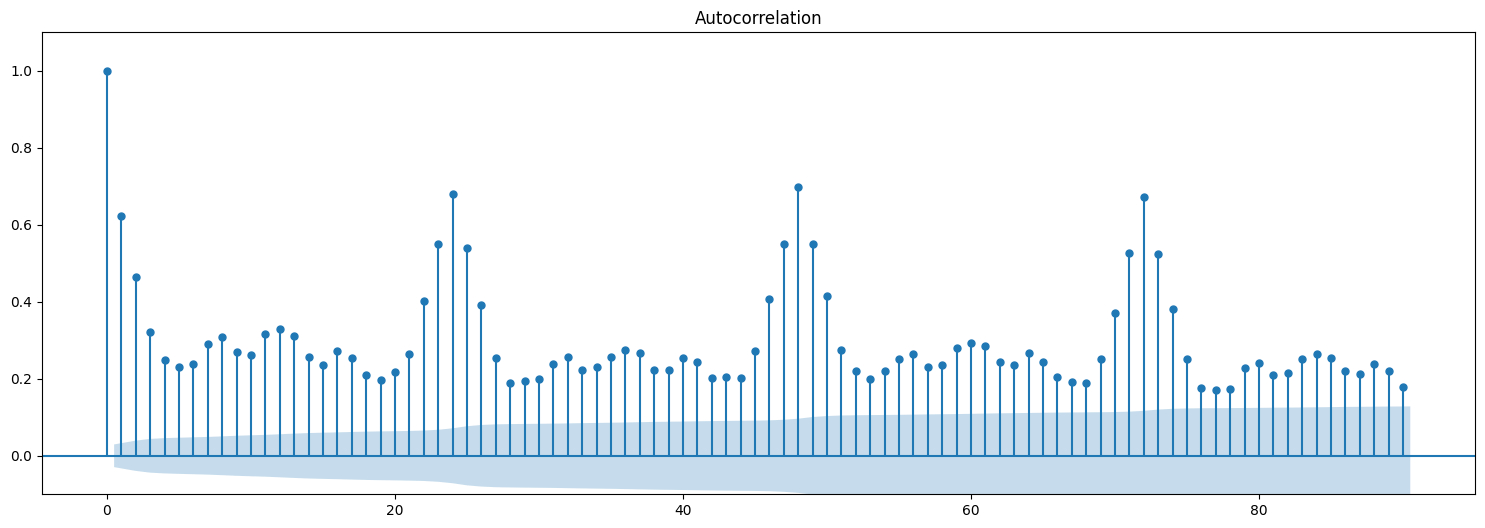

In [9]:
fig = tsaplots.plot_acf(data['num_orders'], lags=90)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show()

## <a id='toc3_3_'></a>[<font color='orange'>**Анализ трендов, сезонности**</font>](#toc0_)

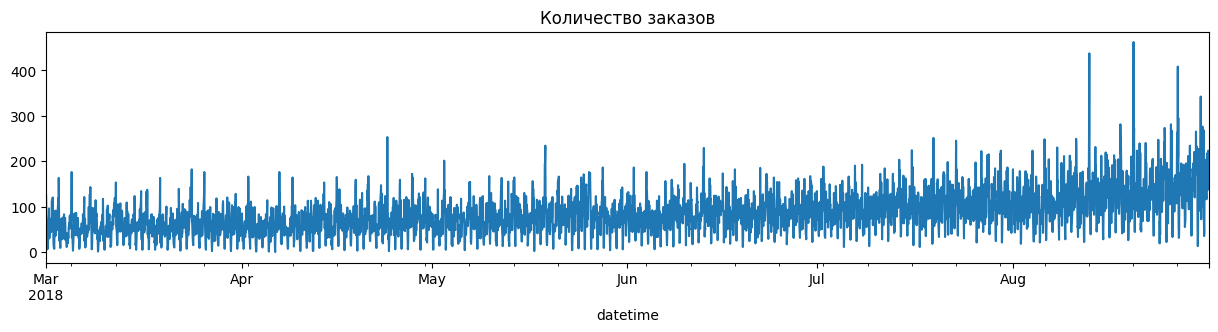

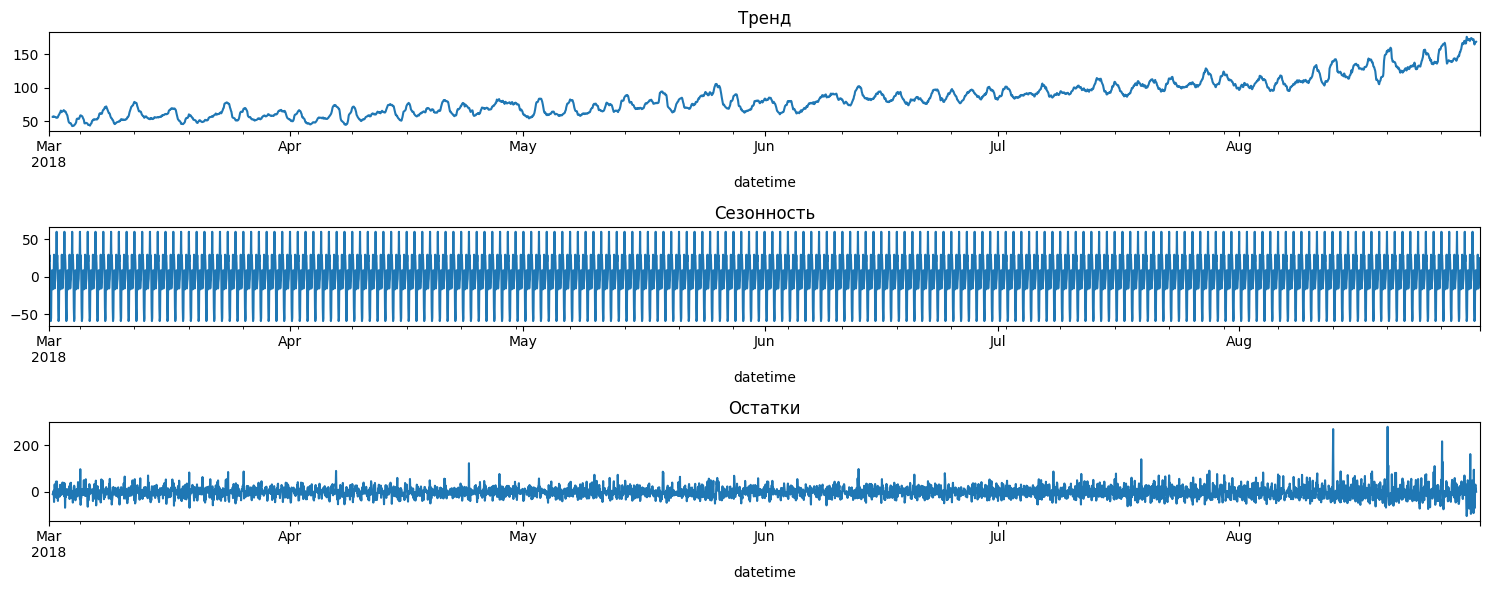

In [10]:
decomposed = seasonal_decompose(data['num_orders'])

plt.figure(figsize=(15, 3))
plt.title('Количество заказов')
data['num_orders'].plot()
plt.show()

plt.figure(figsize=(15, 6))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остатки')
plt.tight_layout()

<font color='orange'>**Анализ трендов, сезонности - посмотрим ближе**</font>

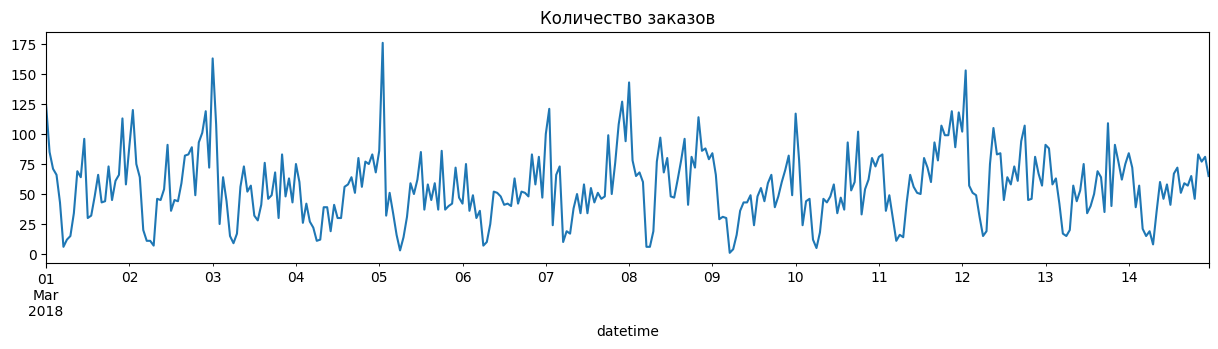

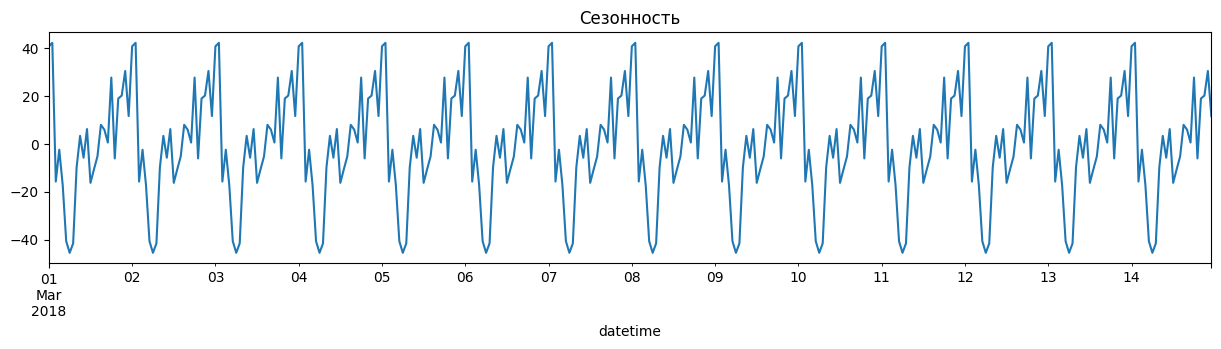

In [11]:
decomposed = seasonal_decompose(data['num_orders']['2018-03-01':'2018-03-14'])

plt.figure(figsize=(15, 3))
plt.title('Количество заказов')
data['num_orders']['2018-03-01':'2018-03-14'].plot()
plt.show()

plt.figure(figsize=(15, 3))
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.show()

## <a id='toc3_4_'></a>[<font color='orange'>**Проверка на стационарность**</font>](#toc0_)

In [12]:
ts = data['num_orders']
st_test = adfuller(ts, regression='ctt')

print('Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный')
if st_test[1] < 0.05:
    print('Наш ряд стационарный')
else:
    print('Ряд нестационарный')

Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный
Наш ряд стационарный


<font color='orange'>**Анализ: вывод**</font>
- Существует тренд (количество заказов постепенно растёт), в строгом смысле данные не стационарные (хотя по тесту Дики-Фуллера являются стационарыми)
- Также существует квадратичный тренд ближе к концу данных
- Прослеживается сезонность в данных, в течении дня
- Необходимо делать минимум 24 лага для захвата интервала в сезонности, но сделаю 168 лагов, за всю неделю

# <a id='toc4_'></a>[Подготовка признаков](#toc0_)

<font color='orange'>**Создание признаков**</font>

Добавляю признаки:
- Связанные с датой (год, месяц, день, день недели, час)
- Лаг
- Скользящее среднее

In [13]:
# Создание функции
def make_features(data, max_lag, rolling_mean_size):
    # Date
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['day_of_week'] = data.index.dayofweek
    data['hour'] = data.index.hour
    # Lag
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    # Rolling mean
    data['rolling_mean'] = data['num_orders'].shift().rolling(
        rolling_mean_size).mean()

In [14]:
# Создание признаков
make_features(data, 168, 10)

<ipython-input-13-1924bd424468>:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
<ipython-input-13-1924bd424468>:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
<ipython-input-13-1924bd424468>:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

<font color='orange'>**Деление на трейн/тест**</font>

In [15]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

X = train.drop('num_orders', axis=1)
y = train['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

<font color='orange'>**Осмотр после изменения**</font>

In [16]:
display(data.head(3))

,num_orders,year,month,day,day_of_week,hour,lag_1,lag_2,lag_3,lag_4,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,1,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,2,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# <a id='toc5_'></a>[Обучение](#toc0_)

In [17]:
# Словарь для составления итоговой таблицы результатов
results = {}
best_parameters = {}

<font color='orange'>**Функция для гридсерча и оценки моделей**</font>

- В этой функции использую TimeSeriesSplit

<p><img style="float:center; margin:20px; padding:20px; max-height:250px" src="https://www.researchgate.net/publication/350005681/figure/fig1/AS:1000388517974017@1615522617169/Expanding-window-5-split-time-series-cross-validation.png"></p>
<p style="text-align:justify;">


In [18]:
def model_eval_TSS(model_name, model, parameters):

    # Параметры для скоринга и кросс-валидации
    scoring = {'RMSE':'neg_root_mean_squared_error', "R2" : "r2", 'MAE' : 'neg_mean_absolute_error'}
    tscv = TimeSeriesSplit(4)

    # Гридсерч
    grid_search_model = GridSearchCV(model, parameters, cv=tscv, scoring=scoring, n_jobs=-1, refit="RMSE")
    grid_search_model.fit(X, y)
    # Сохраняю метрики лучшей модели

    RMSE = -grid_search_model.best_score_
    MAE = -grid_search_model.cv_results_['mean_test_MAE'][grid_search_model.best_index_]
    R2 = grid_search_model.cv_results_['mean_test_R2'][grid_search_model.best_index_]

    # Вывод на экран метрик
    print('Метрики для модели', model_name)
    print('RMSE =', RMSE)
    print('MAE =', MAE)
    print('R2 =', R2)
    print('Best parameters', grid_search_model.best_params_)

    # Время предсказания
    start_time = time.time()
    grid_search_model.predict(X)
    predict_time = time.time() - start_time
    
    # Сохраняю в общую таблицу метрики для модели
    results[model_name] = [RMSE, MAE, R2, predict_time]
    best_parameters[model_name] = grid_search_model.best_params_
    return None

## <a id='toc5_1_'></a>[<font color='orange'>**Dummy + Arima**</font>](#toc0_)

<font color='orange'>**Dummy модель**</font>
- Создам dummy модель по предыдущему дню
- Она будует использована для сравнения с ML моделями

In [19]:
print("Среднее количество заказов в час:",
      test['num_orders'].mean())

# Предсказания для dummy
pred_previous = test['num_orders'].shift()
pred_previous.iloc[0] = train['num_orders'].iloc[-1]

# Метрики для dummy
RMSE_d = mean_squared_error(pred_previous, test['num_orders'])**0.5
MAE_d = mean_absolute_error(pred_previous, test['num_orders'])
R2_d = r2_score(pred_previous, test['num_orders'])

# Вывожу
print("RMSE =", RMSE_d)
print('MAE =', MAE_d)
print('R2 =', R2_d)

# Сохраняю в общие результаты
results['dummy'] = [RMSE_d, MAE_d, R2_d, None]

Среднее количество заказов в час: 139.55656108597285
RMSE = 58.856486242815066
MAE = 44.97285067873303
R2 = -0.013102364208386286


<font color='orange'>**ARIMA модель**</font>

In [20]:
# Модель и предсказания
arima = ARIMA(data['num_orders'][:3806])
model_a = arima.fit()
y_pred = pd.Series(model_a.forecast(
    442)[0], index=data['num_orders'][3806:4416].index)
y_true = data['num_orders'][3806:4416]

# Метрики
RMSE_a = mean_squared_error(y_pred, y_true)**0.5
MAE_a = mean_absolute_error(y_pred, y_true)
R2_a = r2_score(y_pred, y_true)

# Вывожу
print("RMSE =", RMSE_a)
print('MAE =', MAE_a)
print('R2 =', R2_a)

# Сохраняю в общие результаты
results['arima'] = [RMSE_a, MAE_a, R2_a, None]

RMSE = 80.3642097404836
MAE = 63.06756286679472
R2 = 0.0


## <a id='toc5_2_'></a>[<font color='orange'>**Линейные модели**</font>](#toc0_)

<font color='orange'>**Модель ElasticNet**</font>

In [21]:
parameters = {"alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
model_eval_TSS('ElasticNet', ElasticNet(random_state=12345), parameters)

Метрики для модели ElasticNet
RMSE = 22.129444434560195
MAE = 16.57932117353865
R2 = 0.6131862268326196
Best parameters {'alpha': 10}


<font color='orange'>**Модель Lasso**</font>

In [22]:
parameters = {"alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
model_eval_TSS('Lasso', Lasso(random_state=12345), parameters)

Метрики для модели Lasso
RMSE = 21.96109530502224
MAE = 16.425409658370967
R2 = 0.6196845683639057
Best parameters {'alpha': 10}


<font color='orange'>**Модель Ridge**</font>

In [23]:
parameters = {"alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
model_eval_TSS('Ridge', Ridge(random_state=12345), parameters)

Метрики для модели Ridge
RMSE = 22.859123006116082
MAE = 17.257669031425813
R2 = 0.5855943826143886
Best parameters {'alpha': 100}


## <a id='toc5_3_'></a>[<font color='orange'>**Дерево, случайный лес, SVM**</font>](#toc0_)

<font color='orange'>**Модель решающего дерева**</font>

In [24]:
parameters = {"splitter": ["best", "random"],
              "max_depth": [1, 3, 5, 7, 9, 11, 12],
              "min_samples_leaf": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              "min_weight_fraction_leaf": [0.1, 0.2, 0.3, 0.4, 0.5],
              "max_features": ["auto", "log2", "sqrt", None]}
model_eval_TSS('Решающее дерево',
               DecisionTreeRegressor(random_state=12345), parameters)

Метрики для модели Решающее дерево
RMSE = 27.50896891613334
MAE = 20.26481478027594
R2 = 0.4073904165670297
Best parameters {'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.1, 'splitter': 'best'}


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


<font color='orange'>**Модель случайного леса**</font>

In [25]:
parameters = {"n_estimators": [1, 10, 100, 500],
              "max_depth": [2, 4, 6, 8, 10]}
model_eval_TSS('Случайный лес',
               RandomForestRegressor(random_state=12345), parameters)

Метрики для модели Случайный лес
RMSE = 22.87200381632204
MAE = 16.801915275326667
R2 = 0.5897396476649712
Best parameters {'max_depth': 10, 'n_estimators': 500}


<font color='orange'>**Модель SVM**</font>

In [26]:
parameters = {'kernel': ('linear', 'rbf', 'poly')}
model_eval_TSS('SVM', SVR(), parameters)

Метрики для модели SVM
RMSE = 31.301267390558685
MAE = 23.283655021610798
R2 = 0.20501983598915377
Best parameters {'kernel': 'poly'}


## <a id='toc5_4_'></a>[<font color='orange'>**Градиентный бустинг**</font>](#toc0_)

<font color='orange'>**Модель LGBM**</font>

In [27]:
parameters = {'learning_rate': [0.01, 0.05, 0.1, 0.25, 0.5]}
model_eval_TSS('LGBMRegressor', LGBMRegressor(), parameters)

Метрики для модели LGBMRegressor
RMSE = 23.040256507744942
MAE = 16.973777479187905
R2 = 0.5831259433945055
Best parameters {'learning_rate': 0.05}


<font color='orange'>**Модель Catboost**</font>

In [28]:
parameters = {'learning_rate': [0.01, 0.05, 0.1, 0.25, 0.5]}
model_eval_TSS('Catboost', CatBoostRegressor(
    logging_level='Silent'), parameters)

Метрики для модели Catboost
RMSE = 22.595848233043686
MAE = 16.551958739835996
R2 = 0.5994098100567953
Best parameters {'learning_rate': 0.01}


<font color='orange'>**Модель линейной регрессии**</font>

In [30]:
model = LinearRegression()
model.fit(X[:3000], y[:3000])
y_pred = model.predict(X[3000:])
y_true = y[3000:]

# Метрики
RMSE_l = mean_squared_error(y_pred, y_true)**0.5
MAE_l = mean_absolute_error(y_pred, y_true)
R2_l = r2_score(y_pred, y_true)

# Время предсказания
start_time = time.time()
model.predict(X)
predict_time = time.time() - start_time

print("RMSE =", RMSE_l)
print('MAE =', MAE_l)
print('R2 =', R2_l)
# Сохраняю в общие результаты
results['LinearRegression'] = [RMSE_l, MAE_l, R2_l, predict_time]

RMSE = 27.091946897105835
MAE = 19.592714679134144
R2 = 0.2645719901414154


# <a id='toc6_'></a>[Тестирование](#toc0_)

## <a id='toc6_1_'></a>[<font color='orange'>**Результаты моделей получены**</font>](#toc0_)

In [31]:
results_df = pd.DataFrame(results, index=['RMSE', 'MAE', 'R2', 'Predict_time'])

In [32]:
display(results_df.transpose().sort_values(by='RMSE'))

,RMSE,MAE,R2,Predict_time
Lasso,21.961095,16.425410,0.619685,0.014451
ElasticNet,22.129444,16.579321,0.613186,0.007385
Catboost,22.595848,16.551959,0.599410,0.013309
Ridge,22.859123,17.257669,0.585594,0.017787
Случайный лес,22.872004,16.801915,0.589740,0.205106
LGBMRegressor,23.040257,16.973777,0.583126,0.021238
LinearRegression,27.091947,19.592715,0.264572,0.027417
Решающее дерево,27.508969,20.264815,0.407390,0.003621
SVM,31.301267,23.283655,0.205020,0.713152
dummy,58.856486,44.972851,-0.013102,NaN


<font color='orange'>**Выбираю LGBMRegressor для тестирования**</font>

In [44]:
results_df_test = pd.DataFrame(None, index=['RMSE', 'MAE', 'R2'])

In [45]:
best_parameters['LGBMRegressor']

{'learning_rate': 0.05}

In [46]:
model = LGBMRegressor(learning_rate=0.05)
model.fit(X, y)
y_pred = model.predict(X_test)

results_df_test['LGBM_test'] = [mean_squared_error(y_pred, test['num_orders'])**0.5,
                           mean_absolute_error(y_pred, test['num_orders']),
                           r2_score(y_pred, test['num_orders'])]

<font color='orange'>**А также модель Lasso для тестирования**</font>

In [47]:
best_parameters['Lasso']

{'alpha': 10}

In [48]:
model = Lasso(alpha=10)
model.fit(X, y)
y_pred = model.predict(X_test)

results_df_test['Lasso_test'] = [mean_squared_error(y_pred, test['num_orders'])**0.5,
                            mean_absolute_error(y_pred, test['num_orders']),
                            r2_score(y_pred, test['num_orders'])]

## <a id='toc6_2_'></a>[<font color='orange'>**Итоговый тест**</font>](#toc0_)

In [49]:
results_df_test['LGBM_vs_dummy'] = abs(
    results_df_test['LGBM_test'] / results_df['dummy'][:3] - 1) * 100
results_df_test['Lasso_vs_dummy'] = abs(
    results_df_test['Lasso_test'] / results_df['dummy'][:3] - 1) * 100
display(results_df_test)
print('model_vs_Dummy столбец - Насколько процентов итоговая модель лучше Dummy')

,LGBM_test,Lasso_test,LGBM_vs_dummy,Lasso_vs_dummy
RMSE,36.976479,34.487655,37.175185,41.403815
MAE,26.421094,25.403447,41.251014,43.513816
R2,0.188138,0.420243,1535.910675,3307.383563


model_vs_Dummy столбец - Насколько процентов итоговая модель лучше Dummy


# <a id='toc7_'></a>[**Общий вывод**](#toc0_)
1. Проведен анализ автокорреляции и сезонности для выбора размера дополнительных признаков
2. Созданы дополнительные признаки (лаг и скользящее среднее)
3. Построено 10 моделей ML и Dummy модель (для сравнения) на валидационных данных
4. Лучшие модели (на валидационных данных) линейные с регуляризацией и градиентный бустинг (Catboost)
5. И модель Лассо и градиентный бустинг дают примерно одинаковый результат, лучше константной модели на 37-41% в метрике RMSE
6. Некоторые линейные модели предсказывают быстрее чем градиентный бустинг, и в тесте они немного лучше
7. Линейные модели с регуляризацией работают лучше, чем простая линейная регрессия (вероятно из-за коллинеарных признаков)